
# Initial Experiments
Through these experiments, we want to show two issues in studying interaction between drugs and domains.
1. **First problem:** That when a drug interacts with a single-domain protein (with domain X), even if we correctly conclude that it interacts with domain X, It may not interact with another single domain protein that has domain X. This is easy to check using Data. For this, we need some negative interaction data and for that, we can go to affinity data.  
2. **Second Problem:** is about multi-domain proteins and that is when a drug is interacting with a multi-domain protein (with domains X and Y), we can’t confidently say if this drug interacts with X or Y or both or either or neither meaning several cases are possible:  
    - The drug interacts with protein because it interacts directly with X
    - The drug interacts with protein because it interacts directly with Y
    - The drug interacts with protein because X and Y are both present
    - The drug interacts with protein because either of X or Y are present
    - The drug interacts because X and Y are present and they are in certain configuration with respect to each other or other extrinsic properties of the protein besides existence of X and Y.
    - The drug interacts for a completely irrelevant reason to existence of X or Y. 
    
There might be some overlap between the problem-1 and problem-2. But conceptually, we can say that first problem arises when trying to go from a drug-domain interaction to drug-protein interaction and the second problem arises when we go in the reverse direction. We want to see if we can quantitatively assess how prevalent these problems are or at least illuminate them as much as possible.

## from positive interactions to negative
This means we infer drug-domain interactions from drug interactions of single domain proteins, and then find examples where the same domain occurs in other proteins but doesn't interact with same drugs (we have a negative interaction for it in our dataset). for this, the negative interactions are very important. common drug-target interaction databases only have positive interactions and they assume lack of a pair in the dataset to mean lack of interaction, which is obviously not correct. However there are some researches that also collect negative interaction data like [Coelho2016](https://doi.org/10.1371/journal.pcbi.1005219) where they have used affinity data to extract some negative interactions

### First attempt using Coelho2016 datset
This dataset is based on [Coelho2016](https://doi.org/10.1371/journal.pcbi.1005219) paper and contains negative and positive interactions. Negative interactions are extracted from BindingDB and BioLip databases, even though BioLip is questionable as a source of negative interactions because it is extracted from strucutres of drug-target complexes in the PDB, while we are more interested in those based on chemical assays.
To use this dataset to search for cases of problem-1, we create a table where for each pair of drug D and proteins P, where the protein is single-domain M, we list all other proteins Q that have the same domain M and divide them into three groups:
1. **Pos:** those that there is a positive interaction in the dataset between Q and D
1. **Neg:** those that there is a negative interaction in the dataset between Q and D
1. **Unk:** those that there is no interaction information in the dataset between Q and D

In [28]:

#first we read the dataset and 

interacts = dict() # for each pair in the dataset (key),  it shows the annotations True/False (interaction/non-interaction) if it exists in the dataset. we basically store all dataset infromation here.
uniprot_ids = set() # set of uniprot IDs for the purpose of collecting their pfam domain annotations
drugsof= dict() # we want positive interactions for single domain proteins so we store them here to be readily available

import pandas
for f in ["drugbank_DTIs_REAL_NEGS.txt","test_data_sc_and_bc.txt","yamanishi_DTIs_REAL_NEGS.txt"]:
    df = pandas.read_csv("DTIPred/"+f, sep = "\t", header = None)
    for index , row in df.iterrows():
        pid  = row[0]
        did  = row[1]
        interaction_exist  = row[2]
        uniprot_ids.add(pid)
#         if (pid,did) in interacts:
#             if (interacts[(pid,did)] != interaction_exist):
#                 print ("error repeat", (pid,did))
#         else:
        interacts[(pid,did)] = interaction_exist 
        if interaction_exist == 1:               
            if pid in drugsof:
                drugsof[pid].append(did)
            else:
                drugsof[pid] = [did]
        
with open ("DTIPred/uniprotids.txt", "w") as pf:
    pf.writelines("\n".join(uniprot_ids))
    
        
        

In [42]:

# here, we read the domain annotations we have downloaded from uniprot.

import pandas

def extract_items(field):
    if ";" not in field:
        return []
    else:
        spl = field.split(";")
        for s in spl:
            if len(s) <=1:
#                 print(s)
                spl.remove(s)
        return spl

proteinswith = dict() #for each domain (pfam ID), this will store the set of proteins (uniprot IDs) that have this domain
domainsof  = dict () #for each protein (uniprot ID), this will store the list of domains (pfam IDs) of that protein
df = pandas.read_csv("DTIPred/uniprotids_annnots.tab", sep = "\t", converters={i: str for i in range(100)})

for index , row in df.iterrows():
    domain_field = row ["Cross-reference (Pfam)"]
    pid = row["yourlist:M20210201A94466D2655679D1FD8953E075198DA83D46A3C"]    
    if True: #conditions for considering a protien such as being human protein or being reviewed
            domain_list = extract_items(domain_field)
            domainsof[pid]= domain_list 
            for dom  in domain_list:
                if dom in proteinswith:
                    proteinswith[dom].append(pid)
                else:
                    proteinswith[dom]= [pid]
        
    
num_domains = {x:len(domainsof[x]) for x in domainsof.keys()}
one_domain = [x for x in domainsof.keys() if len(domainsof[x])==1]

In [43]:

# here we do the calculations, meaning we prepare the table consisting of pairs of single domain proteins (P) and interacting drugs (D) the number of proteins falling to each of the three groups and the ID of these proteins are stored in the next columns

drug_level_examples = "onedomain-protein,domain,interacting_drug,num_pos,num_neg,num_unk,pos,neg,unk\n"
protein_level_exmples  = ""


for p in one_domain:
    m = domainsof[p][0]
    Q_set = proteinswith[m].copy()
    if p in Q_set:
        Q_set.remove(p)        
    if p in drugsof:
        D_set = drugsof[p]
        for d in D_set:
            negs = []
            pos = []
            unk= []
            for q in Q_set:
                if (q,d) in interacts:
                    if interacts[(q,d)]==1:
                        pos.append(q)
                    else:
                        negs.append(q)
                else:
                    unk.append(q)
            row_str= ",".join ([p,m,d,str(len(pos)),str(len(negs)),str(len(unk)),";".join(pos), ";".join(negs), ";".join(unk)])+"\n"
            drug_level_examples+= row_str
            
with open("result_drug_level.csv","w") as outf:
    outf.writelines(drug_level_examples)
    

TypeError: sequence item 2: expected str instance, float found

The result of this experiments showed that we couldn't find occurance of the problem-1 with this dataset. This can be due to small number of negative interactions that we have which can be due the the dataset being old. Therefore, we recollect the negative interactions from BindingDB to do this experiment again.

### Second attempt using BindingDB
we downloaded the BindingDB in tsv format. There were few issues here. First of all, for affinity, there are several measures here including Ki, Kd, IC50, and EC50. The literature that use affinity to obtain negative interactions don't clarfiy which of these measures they have used except one preprint that says they use Ki or IC50, even though based on a search that I did Kd is the most relevant measure for durg binding to proteins. 
Another problem is that some of the rows (interactions) in the bindingDB don't have a uniprot ID or have multiple chains. these cases altogether constitute less than 13% of interactions in the dataset. So for now, we ignore them because it makes the life much easier. 

In [6]:
import pandas 
import numpy


col_names = pandas.read_csv("BindingDB_All_2021m0.tsv/BindingDB_All.tsv", sep = "\t", nrows=0).columns
# types_dict = {"Ki (nM)": float,"Kd (nM)": float,"IC50 (nM)": float,"EC50 (nM)": float}
# types_dict.update({col: str for col in col_names if col not in types_dict})
types_dict={col: str for col in col_names}

df = pandas.read_csv("BindingDB_All_2021m0.tsv/BindingDB_All.tsv", sep = "\t",error_bad_lines=False,dtype=types_dict)

single_chain_mask = df["Number of Protein Chains in Target (>1 implies a multichain complex)"]=="1"
hasswissprot_mask = numpy.logical_not(df["UniProt (SwissProt) Primary ID of Target Chain"].isna())
num_singlechain_interactions  = len(df.loc[single_chain_mask,:])
num_all_interactions = len(df)
singlechain_interactions_with_swissprot_id_mask  = single_chain_mask & hasswissprot_mask
num_singlechain_interactions_with_swissprot_id = len(df.loc[singlechain_interactions_with_swissprot_id_mask,:])

b'Skipping line 896772: expected 193 fields, saw 205\nSkipping line 896798: expected 193 fields, saw 205\n'
b'Skipping line 929491: expected 193 fields, saw 205\n'
b'Skipping line 952161: expected 193 fields, saw 265\n'
b'Skipping line 1355895: expected 193 fields, saw 241\n'
b'Skipping line 1469800: expected 193 fields, saw 241\nSkipping line 1469801: expected 193 fields, saw 241\nSkipping line 1469802: expected 193 fields, saw 241\nSkipping line 1469803: expected 193 fields, saw 241\nSkipping line 1469804: expected 193 fields, saw 241\nSkipping line 1469805: expected 193 fields, saw 241\nSkipping line 1469806: expected 193 fields, saw 241\nSkipping line 1469807: expected 193 fields, saw 241\nSkipping line 1469808: expected 193 fields, saw 241\n'
b'Skipping line 1483073: expected 193 fields, saw 205\n'
b'Skipping line 1502296: expected 193 fields, saw 241\nSkipping line 1502297: expected 193 fields, saw 241\nSkipping line 1502298: expected 193 fields, saw 241\nSkipping line 1502299: e

In [7]:
num_singlechain_interactions/num_all_interactions

0.9533262698708022

In [8]:
num_singlechain_interactions_with_swissprot_id/num_all_interactions

0.8723724424834056

#### Analysis of the distribution of affiniy values to select a threshold
it seems like that here the unit of Ki, Kd, and IC50 are in nanoMolar while in the literature, the thresholds (1, 10 , 30) are expressed in microMolar so we should use 1000,10000, 30000 but the following plot, which shows the distribuiton of kd, makes this unbelievable. But what can we do? we should go with what numbers say and assume that everything is correct.

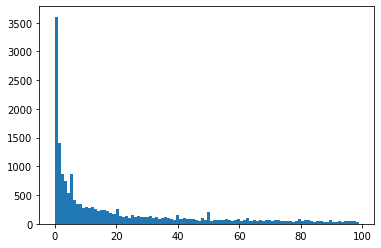

In [29]:
import matplotlib.pyplot as plt
vals = df["Kd (nM)"].values[df["Kd (nM)"]<100]
plt.hist(vals,bins=100)
plt.show()

In [9]:

import numpy


interaction_threshold = 1000
noninteraction_threshold = 10000

def valid_number(x):
    try:
        if type(x) == str:
            x = x.replace(">","")
            x = x.replace("<","")
            x = x.replace(" ","")
        a  = float(x)
        if a == 0:
            return False
        return a
    except:
        return False

easy_df = df.loc[singlechain_interactions_with_swissprot_id_mask,:].copy()

    
bin_interaction = numpy.array([""] * len (easy_df))

Ki_col= easy_df["Ki (nM)"].values 
Kd_col= easy_df["Ki (nM)"].values 
IC50_col= easy_df["IC50 (nM)"].values 
EC50_col= easy_df["EC50 (nM)"].values 

conflict_rows = []
incomplete_rows = []
for i in range(len(easy_df)):
    num_pdecisions = 0
    num_ndecisions = 0
    Ki = valid_number(Ki_col[i])
    Kd = valid_number(Kd_col[i])
    IC50 = valid_number(IC50_col[i])
    EC50 = valid_number(EC50_col[i])

        
    if Ki:
        if Ki < interaction_threshold:
            bin_interaction[i] = True
            num_pdecisions += 1
        elif Ki> noninteraction_threshold:
            bin_interaction[i] = False
            num_ndecisions += 1
    if Kd:
        if Kd < interaction_threshold:
            bin_interaction[i] = True
            num_pdecisions += 1
        elif Kd > noninteraction_threshold:
            bin_interaction[i] = False
            num_ndecisions += 1
    if IC50:
        if IC50 < interaction_threshold:
            bin_interaction[i] = True
            num_pdecisions += 1
        elif IC50 > noninteraction_threshold:
            bin_interaction[i] = False
            num_ndecisions += 1
    if EC50:
        if EC50 < interaction_threshold:
            bin_interaction[i] = True
            num_pdecisions += 1
        elif EC50> noninteraction_threshold:
            bin_interaction[i] = False
            num_ndecisions += 1
    if (num_pdecisions>0) and (num_ndecisions>0) :
        conflict_rows.append((i,num_pdecisions,num_ndecisions))
        bin_interaction[i] = ""
    if (num_ndecisions<1) and (num_pdecisions<1):
        incomplete_rows.append(i)

print("number of rows with undecided binary interaction:", len(incomplete_rows))
print("number of rows with conflicting binary interaction:", len(conflict_rows))        


number of rows with undecided binary interaction: 479039
number of rows with conflicting binary interaction: 74


In [10]:
easy_df["bin_interaction"] = bin_interaction 

In [11]:
easy_df["bin_interaction"].value_counts()

T    1032157
      479113
F     300959
Name: bin_interaction, dtype: int64

In [12]:
easy_df_easy_bin = easy_df.loc[easy_df["bin_interaction"] != "",["UniProt (SwissProt) Primary ID of Target Chain","PubChem CID","bin_interaction"]].copy()

In [23]:
target_uniprots  = easy_df["UniProt (SwissProt) Primary ID of Target Chain"].values
unique_target_uniprots  = set(target_uniprots)
with open("unique_uniprots.txt", "w") as outf:
    outf.writelines("\n".join(unique_target_uniprots))

In [48]:

#first we read the dataset and 

interacts = dict() # for each pair in the dataset (key),  it shows the annotations True/False (interaction/non-interaction) if it exists in the dataset. we basically store all dataset infromation here.
uniprot_ids = set() # set of uniprot IDs for the purpose of collecting their pfam domain annotations
drugsof= dict() # we want positive interactions for single domain proteins so we store them here to be readily available
num_occurrance = dict()



import pandas



for index , row in easy_df_easy_bin.iterrows():
    pid  = row["UniProt (SwissProt) Primary ID of Target Chain"]
    did  = row["PubChem CID"]
    interaction_exist  = row["bin_interaction"]
    uniprot_ids.add(pid)
    if (pid,did) in interacts:
        num_occurrance[(pid,did)] +=1
    else:
        interacts[(pid,did)] = interaction_exist
        num_occurrance[(pid,did)] = 1
        if interaction_exist == "T":
            if (type(did)== str) and (type (pid)==str):
                if pid in drugsof:
                    drugsof[pid].add(did)
                else:
                    drugsof[pid] = set([did])
        
# with open ("DTIPred/uniprotids.txt", "w") as pf:
#     pf.writelines("\n".join(uniprot_ids))
    
top_repetitions = sorted(num_occurrance.items(), key=lambda x: x[1], reverse=True)        
        

In [49]:
deletions = set()
for k in interacts:
    if (type(k[0])!=str or type(k[1]) !=str):
        deletions.add(k)


In [50]:
for i in deletions:
    del interacts[i]


In [51]:
len(interacts)

978169

In [52]:
# in this part, we do the exact same thing we did for the Coelho2016 dataset except with new data from bindingDB
# we read the domain annotations we have downloaded from uniprot.

import pandas

def extract_items(field):
    if ";" not in field:
        return []
    else:
        spl = field.split(";")
        for s in spl:
            if len(s) <=1:
#                 print(s)
                spl.remove(s)
        return spl

proteinswith = dict() #for each domain (pfam ID), this will store the set of proteins (uniprot IDs) that have this domain
domainsof  = dict () #for each protein (uniprot ID), this will store the list of domains (pfam IDs) of that protein
df = pandas.read_csv("unique_uniprots_domains.tab", sep = "\t", converters={i: str for i in range(100)})

for index , row in df.iterrows():
    domain_field = row ["Cross-reference (Pfam)"]
    pid = row["yourlist:M20210208A94466D2655679D1FD8953E075198DA843865FQ"]    
    if True: #conditions for considering a protien such as being human protein or being reviewed
            domain_list = extract_items(domain_field)
            domainsof[pid]= domain_list 
            for dom  in domain_list:
                if dom in proteinswith:
                    proteinswith[dom].append(pid)
                else:
                    proteinswith[dom]= [pid]
        
    
num_domains = {x:len(domainsof[x]) for x in domainsof.keys()}
one_domain = [x for x in domainsof.keys() if len(domainsof[x])==1]

In [53]:

# here we do the calculations, meaning we prepare the table consisting of pairs of single domain proteins (P) and interacting drugs (D) the number of proteins falling to each of the three groups and the ID of these proteins are stored in the next columns

drug_level_examples = "onedomain-protein,domain,interacting_drug,num_pos,num_neg,num_unk,pos,neg,unk\n"
protein_level_exmples  = ""


for p in one_domain:
    m = domainsof[p][0]
    Q_set = proteinswith[m].copy()
    if p in Q_set:
        Q_set.remove(p)        
    if p in drugsof:
        D_set = drugsof[p]
        for d in D_set:
            negs = []
            pos = []
            unk= []
            for q in Q_set:
                if type(q)== float:
                    print("error-q:", q)
                if (q,d) in interacts:
                    if interacts[(q,d)]=="T":
                        pos.append(q)
                    else:
                        negs.append(q)
                else:
                    unk.append(q)
            if (type(p) == float):
                print("error-p:", p)
            if (type(m) == float):
                print("error-m:", m)
            if (type(d) == float):
                print("error-d:", d)
                
            row_str= ",".join ([p,m,d,str(len(pos)),str(len(negs)),str(len(unk)),";".join(pos), ";".join(negs), ";".join(unk)])+"\n"
            drug_level_examples += row_str
            
with open("result_drug_level.csv","w") as outf:
    outf.writelines(drug_level_examples)
    

# TRASH BELOW

In [13]:
with open ("columns.txt", "w") as txf:
    txf.writelines("\n".join(df.columns))

In [39]:
easy_df_easy_bin["bin_interaction"].iloc[1]

'T'

In [46]:
proteinswith

{'PF00988': ['P0A6F1', 'P31327'],
 'PF00117': ['P0A6F1', 'P31327', 'P0A7E5'],
 'PF00194': ['P35219',
  'B4DUH8',
  'Q8N1Q1',
  'A0A024RBW9',
  'V9HW21',
  'P23280',
  'P22748',
  'P35218',
  'V9HWE3',
  'A8K3J4',
  'Q16790',
  'P00915',
  'P43166',
  'Q9Y2D0',
  'P00918',
  'Q9ULX7',
  'O43570',
  'P07451',
  'V9HWA3'],
 'PF01419': ['P18670', 'O22321', 'P18674', 'P84801'],
 'PF00064': ['P11485', 'P06818', 'Q9IGQ6', 'P27907'],
 'PF00089': ['P00760',
  'Q59GZ8',
  'Q99895',
  'P00740',
  'P00747',
  'P06870',
  'P00761',
  'Q5NV56',
  'O00187',
  'P05981',
  'P98073',
  'P00743',
  'Q9BZJ3',
  'P00766',
  'P08861',
  'P12544',
  'P08217',
  'P00734',
  'P00775',
  'P24158',
  'P35030',
  'P10323',
  'P07288',
  'P08246',
  'B4DU77',
  'P23946',
  'A0A0A0MQY9',
  'P20231',
  'P00749',
  'Q6PK75',
  'Q9Y5Y6',
  'P04070',
  'P03951',
  'P08709',
  'P00746',
  'Q9UNI1',
  'P08311',
  'P35031',
  'P00750',
  'P00736',
  'P20151',
  'Q7Z5F4',
  'P00772',
  'P08519',
  'P00742',
  'P00763',
  '

In [1]:
import pandas

def extract_items(field):
    if ";" not in field:
        return []
    else:
        spl = field.split(";")
        for s in spl:
            if len(s) <=1:
#                 print(s)
                spl.remove(s)
        return spl
                
    
            
    

df = pandas.read_csv("uniprot.tab", sep ="\t",dtype=str)

n_rows, n_cols  = df.shape

uniprot_ids = df["Entry"]
pfam_ids = df["Cross-reference (Pfam)"].astype(str).values
chembl_ids = df["Cross-reference (ChEMBL)"].astype(str).values

domain_count = dict()
drug_count = dict()


for i in range (n_rows):
    domain_list = extract_items(pfam_ids[i])
    drug_list = extract_items(chembl_ids[i])
    for dom in domain_list:
        if dom in domain_count:
            domain_count[dom] += 1
        else:
            domain_count[dom] = 1
    
    for drug in drug_list:
        if drug in drug_count:
            drug_count[drug] += 1
        else:
            drug_count[drug] = 1
            
    

### Mapping human proteins to pfam domains and DrugBank drugs
this allows us to study the prevalence of mullti-domain prorteins. Each multi-domain protein is a case where the problem two can happen. 


The above scripts allows us to count for each domain the number of proteins that have that domain
we will follow the rest of the job later but for now we focus on the approach where affinity data are used for considering true negative interactinos.

952161## Studying the first problem
for this, we want to collect all human proteins and thier interactions, and look at all single-domain proteins and see the support and confidence for  association between domains and interactions. For a certain domain $\text{M}$, the support will be the the fraction of human proteins that have domain $M$ and the confidene for a drug $D$ will be:

$$ \frac{\text{Number of proteins that have $M$ and interact with $D$}}{\text{Number of proteins with $M$}} $$

### Using negative interactions to find examples of problem one

Here we use a dataset from the [paper](https://doi.org/10.1371/journal.pcbi.1005219). In this paper they have used BindingDB and BioLIP to build a dataset of both positive and negative interactions between proteins and drugs. An affinity threshold have been used to consider them negative.

After having negative interactions we need to find the cases where a drug interacts with a protein with only domain M but it doesn't interact with the many other proteins that have domain M 

to find these examples we devise an algorithm:

   
    for each domain M:
        find all proteins that only have M as their domain and put them in set P
        D = {}
        for each protein p in P:
            add to D all drugs that ineract with P
        //on paper, since domain M interacts with all drugs in D, then all proteins with M should also interact with all drugs in D
        for each drug d in D:
        if any of the proteins Q in NEG(d) has domain D then save them save (p, M, q) in the set of couter examples


so for this we need to have set of all domains and sort them based on frequency. 
for each domain we need all of the proteins that have it and for each protein 
            
            
        

